# **Lab Project - Networking for Big Data**


1.   **Tran Luong Bang - 1956419**
2.   **Gaurav Mohan Ramse - 1965564**





## Install Libraries

In [1]:
!pip install imbalanced-learn

## Import Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import pickle
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
dataFrame = pd.read_csv('/content/gdrive/MyDrive/NBD_data/data_sequence.csv', usecols = ['IP_SRC', 'IP_DST', 'src_port', 'dst_port', 'Protocol','length', 'ttl', 'time'], header=0)
dataFrame

,length,Protocol,ttl,IP_SRC,IP_DST,src_port,dst_port,time
0,95,17,57,23.53.35.140,131.137.126.25,53,48350,1.554872e+09
1,1420,6,56,150.57.136.251,221.244.225.179,80,64918,1.554872e+09
2,52,6,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
3,52,6,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09
4,141,17,58,150.57.190.76,155.70.48.196,50821,27023,1.554872e+09
...,...,...,...,...,...,...,...,...
832763,1454,6,56,150.57.136.251,222.127.201.52,80,62620,1.554872e+09
832764,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09
832765,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09
832766,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09


## Data Preprocessing

### Missing values

In [5]:
dataFrame.isnull().sum()

length      0
Protocol    0
ttl         0
IP_SRC      0
IP_DST      0
src_port    0
dst_port    0
time        0
dtype: int64

### Interval time

In [6]:
dataFrame = dataFrame.assign(InterArrivalTime = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port'], group_keys=False).apply(lambda x: x.time.diff()).fillna(0))
dataFrame

,length,Protocol,ttl,IP_SRC,IP_DST,src_port,dst_port,time,InterArrivalTime
0,95,17,57,23.53.35.140,131.137.126.25,53,48350,1.554872e+09,0.000000
1,1420,6,56,150.57.136.251,221.244.225.179,80,64918,1.554872e+09,0.000000
2,52,6,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09,0.000000
3,52,6,54,180.213.208.201,203.122.136.47,53480,80,1.554872e+09,0.000005
4,141,17,58,150.57.190.76,155.70.48.196,50821,27023,1.554872e+09,0.000000
...,...,...,...,...,...,...,...,...,...
832763,1454,6,56,150.57.136.251,222.127.201.52,80,62620,1.554872e+09,0.000049
832764,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09,0.003948
832765,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09,0.000016
832766,1500,6,60,150.57.136.251,66.132.46.70,873,8878,1.554872e+09,0.000002


### Duplicate packets


In [7]:
dataFrame = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg({'InterArrivalTime':'mean', 'length':'mean', 'ttl': 'mean'}).reset_index()
dataFrame

,IP_SRC,IP_DST,Protocol,src_port,dst_port,InterArrivalTime,length,ttl
0,1.33.128.154,203.122.128.169,17,634,123,0.000000,76.0,53.0
1,10.0.0.31,202.239.228.38,17,57970,53,0.000000,65.0,118.0
2,10.1.200.200,202.239.228.38,17,58089,53,0.000000,68.0,119.0
3,10.1.6.2,202.239.228.38,1,-1,-1,0.380452,56.0,239.0
4,10.10.230.1,202.239.228.38,17,42070,53,0.000000,57.0,51.0
...,...,...,...,...,...,...,...,...
31437,96.226.38.235,131.137.9.254,17,53,63533,0.000000,141.0,58.0
31438,96.226.38.235,131.137.9.254,17,53,63677,0.000000,95.0,58.0
31439,96.226.38.235,131.137.9.254,17,53,64459,0.000000,95.0,58.0
31440,96.226.38.235,131.137.9.254,17,53,65472,0.000000,100.0,58.0


### Target Variable

In [8]:
# Replace Protocol Number to Keyword
dataFrame["Protocol"] = dataFrame["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP", 50: "ESP", 4: "IPv4", 47:"GRE", 89: "OSPFIGP", 97: "ETHERIP", 103: "PIM"})

In [9]:
dataFrame.head()

,IP_SRC,IP_DST,Protocol,src_port,dst_port,InterArrivalTime,length,ttl
0,1.33.128.154,203.122.128.169,UDP,634,123,0.000000,76.0,53.0
1,10.0.0.31,202.239.228.38,UDP,57970,53,0.000000,65.0,118.0
2,10.1.200.200,202.239.228.38,UDP,58089,53,0.000000,68.0,119.0
3,10.1.6.2,202.239.228.38,ICMP,-1,-1,0.380452,56.0,239.0
4,10.10.230.1,202.239.228.38,UDP,42070,53,0.000000,57.0,51.0


In [10]:
dataFrame.Protocol.value_counts()

TCP        11830
ICMP       10615
UDP         8976
ESP            8
IPv4           4
GRE            3
OSPFIGP        3
ETHERIP        2
PIM            1
Name: Protocol, dtype: int64

We decided to explore data with protocols TCP, UDP, ICMP

In [11]:
dataFrame = dataFrame.loc[(dataFrame['Protocol'] == 'TCP') | (dataFrame['Protocol'] == 'UDP') | (dataFrame['Protocol'] == 'ICMP')]

In [12]:
dataFrame.shape

(31421, 8)

### Transmission Pipeline

In [13]:
X = dataFrame[['IP_SRC', 'IP_DST', 'src_port', 'dst_port', 'InterArrivalTime', 'length', 'ttl']]
Y = dataFrame['Protocol']

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

X = X.astype({"src_port": object, "dst_port": object})

print(X.info())

full_pipeline = ColumnTransformer([
    ('encoder', OneHotEncoder(), ['IP_SRC', 'IP_DST', 'src_port', 'dst_port'])
])

X = full_pipeline.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31421 entries, 0 to 31441
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IP_SRC            31421 non-null  object 
 1   IP_DST            31421 non-null  object 
 2   src_port          31421 non-null  object 
 3   dst_port          31421 non-null  object 
 4   InterArrivalTime  31421 non-null  float64
 5   length            31421 non-null  float64
 6   ttl               31421 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.9+ MB
None


In [15]:
X.shape

(31421, 38239)

In [16]:
Y.shape

(31421,)

### Dimentionality Reduction 

In [17]:
svd = TruncatedSVD(n_components=500, n_iter=5, random_state=42)
svdTFit = svd.fit_transform(X)

In [18]:
print(svd.explained_variance_ratio_.sum())

0.5609109784375944


In [19]:
svdTFit.shape

(31421, 500)

### Split Data

In [20]:
x_train, x_test, y_train, y_test = train_test_split(svdTFit, Y, test_size = 0.25, random_state = 0)

In [21]:
x_train.shape

(23565, 500)

In [22]:
x_test.shape

(7856, 500)

### Class Imbalance
we use SMOTE to oversample the train dataset

In [23]:
#Before Oversampling
print("train: ", Counter(y_train))

train:  Counter({'TCP': 8846, 'ICMP': 7977, 'UDP': 6742})


In [24]:
oversample = SMOTE()
x_over, y_over = oversample.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# After oversampling
print("train: ", Counter(y_over))

train:  Counter({'TCP': 8846, 'ICMP': 8846, 'UDP': 8846})


## Classified Model

### Support Vector Machine





**Hyperparameter Tuning**

In [26]:
# Hyperparameter tuning
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]}]

In [27]:
# Random Search CV
clf = RandomizedSearchCV(SVC(), tuned_parameters , cv=5, n_jobs= -1)

**Fitting model**

In [28]:
%%time
# clf.fit(x_over, y_over)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [29]:
# save the model to disk
filename = '/content/gdrive/MyDrive/NBD_data/final_model.sav'
# pickle.dump(clf, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

**Evaluation metrics**

In [30]:
y_pred = loaded_model.predict(x_test)
print(loaded_model.score(x_test, y_test))

0.9623217922606925


In [31]:
print('The best parameters:', loaded_model.best_params_)

The best parameters: {'kernel': 'linear', 'C': 10}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


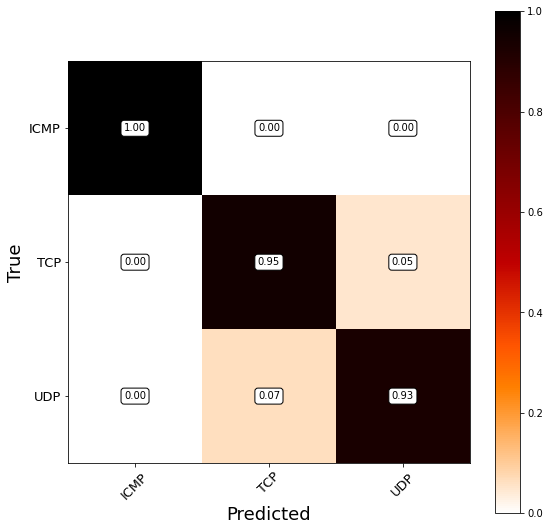

In [32]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gist_heat_r):
    
    '''Confusion Matrix Evaluation'''
    
    plt.figure(figsize=(9,9))
    plt.matshow(df_confusion, cmap=cmap,fignum=1) # imshow
    
    for (i, j), z in np.ndenumerate(df_confusion):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                 bbox=dict(boxstyle='round', facecolor='white'))
    
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45,fontsize = 13)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(tick_marks, df_confusion.index,fontsize = 13)
    plt.tight_layout()
    plt.ylabel("True",fontsize = 18)
    plt.xlabel("Predicted",fontsize = 18)
    plt.grid(False)
    plt.show()

labels = [ "ICMP", "TCP","UDP"]
confmatrix = confusion_matrix(y_test, y_pred,
                 labels=labels)

df_confusion = pd.DataFrame(confmatrix, index=labels, columns=labels)
#Normalizing the matrix
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1),axis=0)

plot_confusion_matrix(df_conf_norm)


In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ICMP       1.00      1.00      1.00      2638
         TCP       0.95      0.95      0.95      2984
         UDP       0.93      0.93      0.93      2234

    accuracy                           0.96      7856
   macro avg       0.96      0.96      0.96      7856
weighted avg       0.96      0.96      0.96      7856



### Random Forest

**Hyperparameter Tuning**

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state = 1)

In [35]:
n_estimators = [100, 300,]
max_depth = [5, 8, 15, ]
min_samples_split = [2, 5]
min_samples_leaf = [2, 5] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

**Fitting model**

In [36]:
# bestF = gridF.fit(x_over, y_over)

In [37]:
# save the model to disk
filename = '/content/gdrive/MyDrive/NBD_data/Random_Forest_model.sav'
# pickle.dump(bestF, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

**Evaluation Metrics**

In [38]:
y_pred = loaded_model.predict(x_test)
print(loaded_model.score(x_test, y_test))

0.9615580448065173


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


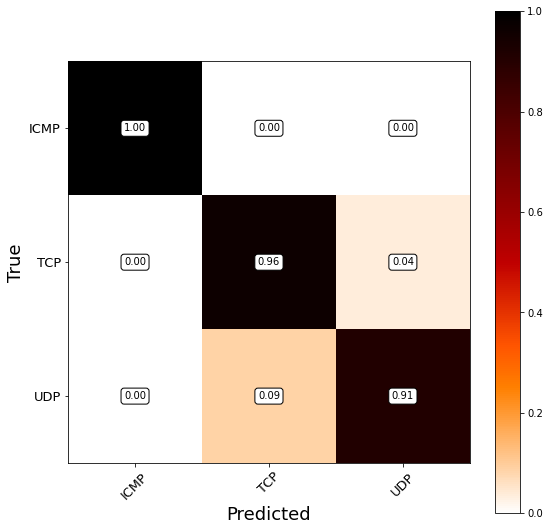

In [39]:
labels = [ "ICMP", "TCP","UDP"]
confmatrix = confusion_matrix(y_test, y_pred,
                 labels=labels)

df_confusion = pd.DataFrame(confmatrix, index=labels, columns=labels)
#Normalizing the matrix
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1),axis=0)

plot_confusion_matrix(df_conf_norm)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        ICMP       1.00      1.00      1.00      2638
         TCP       0.94      0.96      0.95      2984
         UDP       0.95      0.91      0.93      2234

    accuracy                           0.96      7856
   macro avg       0.96      0.96      0.96      7856
weighted avg       0.96      0.96      0.96      7856

